## New Product Page and Conversion Rate

This project provides a step-by-step analysis of an A/B test in Python, under a popular online e-commerce business senario. The objective is to determine whether the company should launch a new version of the product page. 

In [1]:
__author__ = "Jiting Jiang"
__email__ = "jiting.jiang@outlook.com"
__website__ = "https://jitingjiang.github.io/minimal-portfolio/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import scipy.stats as st
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import TTestIndPower

In [4]:
from math import ceil
from datetime import datetime

### Part 1 - The Introduction

To understand whether the company should launch a new verison of the product page site-wide, the team plans to conduct an A/B test on a small group of users to assess the performance of the new page compared to the old one. 

Specifically, the treatment group will be shown the new product landing page, while the control group will see the old page. The randomization unit as well as the unit of analysis are both at the user (id) level. The goal metric is convertion rate. I consider a user converted if he/she buys the product during their user session. I will explain in Part 2 why this metric is considered to be good.  

### Part 2 - Data Preparation

I will use a dataset from Kaggle which consists of about 300,000 user id records. Each record has information about when they visit the page, which type of product page each user land on, and whether they convert or not. 

In [5]:
df_raw = pd.read_csv('/Users/jitingjiang/OneDrive/Career/Courses/ownNotes/PracticeAlong/ab_data.csv')

df_raw.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Before conducting the analysis, it is important to check for any duplicates and missingness in the dataset.

I start with duplicates. Intuitively, the data can include duplicates, since a user can visit the landing page multiple times. The results show that there are 7788 duplicated occurance by user_id.

Next, I want to decide whether I can use any of these duplicates or if I should drop them entirely. The idea is that if the duplicated records have different treatment statuses (i.e., the same user id is presented with both the new_page and old_page during their multiple visits), the experiment would be compromised. In that case, I should drop them altogether. 

To check this, I output the number of duplicated occurances regarding both 'user_id' and 'group' as well as those based solely on 'user_id'. However, the counts are not equal, suggesting that the same user_id may have been presented with different landing page types. 

I also directly output all the duplicated occurances, and not surprisingly, many user_ids are assigned to differnet landing pages during their multiple visits. 

Thus, I will have to drop all the duplicated occurences by setting 'keep=False' within the .duplicated() function.

In [7]:
# check duplicates in 'user_id'
df_raw.duplicated(['user_id'], keep=False).sum()

7788

In [8]:
# check duplicates in 'user_id' and 'group'
df_raw.duplicated(['user_id','group'], keep=False).sum()

3998

In [9]:
# view the duplicates 
duplicates = df_raw[df_raw.duplicated(['user_id'], keep=False)].sort_values('user_id')
duplicates.head(6)

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
11792,630137,2017-01-22 14:59:22.051308,control,new_page,0


In [10]:
# drop the duplicates
df = df_raw.drop_duplicates(['user_id'], keep=False)
df.shape[0]

286690

After dropping the duplicates, I continue to verify the consistency between the 'group' feature and the 'landing_page' feature. Now, it looks good.

In [11]:
# Create new column with boolean values based on conditions
df['is_match'] = df.apply(lambda row: 1 if (row['group'] == 'control' and row['landing_page'] == 'old_page') or
                                           (row['group'] == 'treatment' and row['landing_page'] == 'new_page') else 0, axis=1)
df['is_match'].value_counts()

/var/folders/v9/8fy244t90tz6rjg0b68z06n80000gn/T/ipykernel_23498/2915644582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_match'] = df.apply(lambda row: 1 if (row['group'] == 'control' and row['landing_page'] == 'old_page') or


1    286690
Name: is_match, dtype: int64

I then examine the missingness and there are no missing values found in the dataset.

In [12]:
# check missingness
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
is_match        0
dtype: int64

I also extract the date information from the 'timestamp' feature to create a new feature called 'date'. This transformation will be useful when examining the temporal patterns of the outcome. 

In [13]:
# create 'date' from 'timestamp'
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df

/var/folders/v9/8fy244t90tz6rjg0b68z06n80000gn/T/ipykernel_23498/4087146298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['timestamp']).dt.date


,user_id,timestamp,group,landing_page,converted,is_match,date
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,2017-01-21
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,2017-01-12
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,2017-01-11
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,2017-01-08
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,2017-01-21
...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,2017-01-03
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,2017-01-12
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,2017-01-22
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,2017-01-15


### Part 3 - Run A/B Testing

With the cleaned raw dataset, I can proceed the following steps of an A/B test. 
1. formulate hypothesis
2. decide on goal metrics
3. plot baseline values
4. run power analysis
5. run the experiment (including sanity test)
6. analyze and interpret results

#### 1. Formulate Hypothesis

* H_0: the new product page does NOT affect the conversion rate
* H_a: the new product page DOES affect the conversion rate

#### 2. Decide on Metrics

I explain here why I think conversation rate as a suitable metric for this experiment by showing it being measurable, sensitive, and attributable, although it is the only available outcome in the dataset. 

The conversion rate, in this context, is the percentage of users who visit the product page and subsequently make a purchase. 

* First, conversion rate is measurable. By determining whether a user converts (i.e., makes a purchase) or not, one can calculate the conversion rate easily.

* Second, conversion rate is sensitive. It makes sense to think that users visting the landing page would be more likely to buy the product if they find the page more attractive. 

* Third, conversion rate is attributable. If the conversion rate goes up significantly, one can attribute that increase to the new product page. 

Considering these factors, conversion rate serves as a meaningful and appropriate metric for evaluating the efficacy of the new product page.

#### 3. Plot Baseline Values

To gain insights into the overall dataset, I tabulate the distributions of treatment group indicator and the outcome of whether users converted. The tabulations are performed separately for each variable as well as jointly.

From the analysis, it is clear that half of the (unique) user_id has been assigned to the treatment group and the rest to the control group. Overall, the conversion rate across all observations is approximately 12%. When comparing the conversion rate between the treatment and control group, there does not appear to be much differences. I later perform statistical tests to see if the differences are statistically meaningful. 

In [14]:
# check treatment status
df['group'].value_counts(normalize=True)

treatment    0.500181
control      0.499819
Name: group, dtype: float64

In [15]:
# check outcomes
df['converted'].value_counts(normalize=True)

0    0.88055
1    0.11945
Name: converted, dtype: float64

In [16]:
df.groupby('group')['converted'].value_counts(normalize=True)

group      converted
control    0            0.879827
           1            0.120173
treatment  0            0.881274
           1            0.118726
Name: converted, dtype: float64

#### 4. Run Power Analysis

Although the dataset seems to have all users assigned to the experiment, in reality, this is often not the case. Testing the entire user population is usually impractical and risky. Instead, a small subset of users is typically sampled for the experiment. 

However, before conducting the sampling, one critical question to ask is: how many users should be included in each group? Determining the sample size matters because a larger sample size allows for the detection of smaller differences, if they exist. To address this, power analysis is a common solution.

Here is the three key things to require when conducting power analysis. The output suggests the sample size required in each group. 
* power: 0.8
* significance level: 0.05
* minimum detectable effects (MDE, as decided): 2% (from 13% to 15%)

In [17]:
power = 0.8
alpha = 0.05

In [18]:
# Calculating effect size based on our expected rates
effect_size = proportion_effectsize(0.13, 0.15) 
effect_size

-0.0576728617308947

In [19]:
sample_size = TTestIndPower().solve_power(
    effect_size = effect_size, 
    power = power,
    alpha=alpha,
    nobs1=None) 

n_required = ceil(sample_size)
print(n_required)

4721


#### 5. Run the Experiment

In this case, the randomization unit and the unit of analysis are both at the user level. 

I use the random sampling methods to obtain a sample with 9442 observations, with an equal number assigned to the treatment and control groups, as suggested by the power analysis.

In [20]:
control_sample = df[df['group'] == 'control'].sample(n=n_required, random_state=22)
treated_sample = df[df['group'] == 'treatment'].sample(n=n_required, random_state=22)

In [21]:
sample = pd.concat([control_sample,treated_sample], axis=0).reset_index(drop=True)
sample

,user_id,timestamp,group,landing_page,converted,is_match,date
0,763854,2017-01-21 03:43:17.188315,control,old_page,0,1,2017-01-21
1,690555,2017-01-18 06:38:13.079449,control,old_page,0,1,2017-01-18
2,861520,2017-01-06 21:13:40.044766,control,old_page,0,1,2017-01-06
3,630778,2017-01-05 16:42:36.995204,control,old_page,0,1,2017-01-05
4,656634,2017-01-04 15:31:21.676130,control,old_page,0,1,2017-01-04
...,...,...,...,...,...,...,...
9437,873211,2017-01-05 00:57:16.167151,treatment,new_page,0,1,2017-01-05
9438,631276,2017-01-20 18:56:58.167809,treatment,new_page,0,1,2017-01-20
9439,662301,2017-01-03 08:10:57.768806,treatment,new_page,0,1,2017-01-03
9440,944623,2017-01-19 10:56:01.648653,treatment,new_page,1,1,2017-01-19


#### 6. Analyze Results

I then analyze the selected sample in three main ways. 

First, I calulate the average conversion rate for both the treatment and control groups and the difference between them. 

Second, I present two visualizations. The first visualization compares the conversion rates between the two groups, while the second visualization plots the conversion rates over time for each group.

Third, I conduct formal statistical tests to check whether the observed differences are statisitcally significant. These tests include: 
* Two-sample T test
* Two-sample proportion Z test
* Chi-square test
* Bootstrapping

##### 6.1 Calculate mean difference

In [22]:
control_mean = control_sample['converted'].value_counts(normalize=True)[1]
treated_mean = treated_sample['converted'].value_counts(normalize=True)[1]
print(control_mean, treated_mean)

0.12327896632069477 0.12560898114806185


In [23]:
diff_mean = (treated_mean - control_mean)/control_mean
diff_mean

0.018900343642611683

##### 6.2 Visualize for treatment and control groups

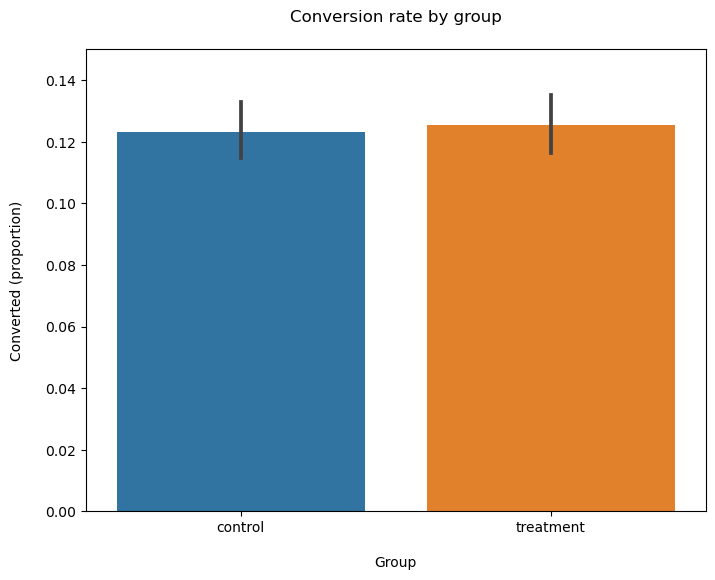

In [24]:
plt.figure(figsize=(8,6))

sns.barplot(x=sample['group'], y=sample['converted'])

plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [25]:
cr_time = sample.groupby(by=["date", "group"], as_index=False)
cr_time = cr_time.agg({"converted": ["count", "sum"]})
cr_time["conversion_rate"] = (cr_time.converted["sum"] / cr_time.converted["count"]) * 100
cr_time.head()

date      group converted     conversion_rate
                             count sum                
0  2017-01-02    control        96  16       16.666667
1  2017-01-02  treatment       104  14       13.461538
2  2017-01-03    control       236  32       13.559322
3  2017-01-03  treatment       209  30       14.354067
4  2017-01-04    control       205  31       15.121951

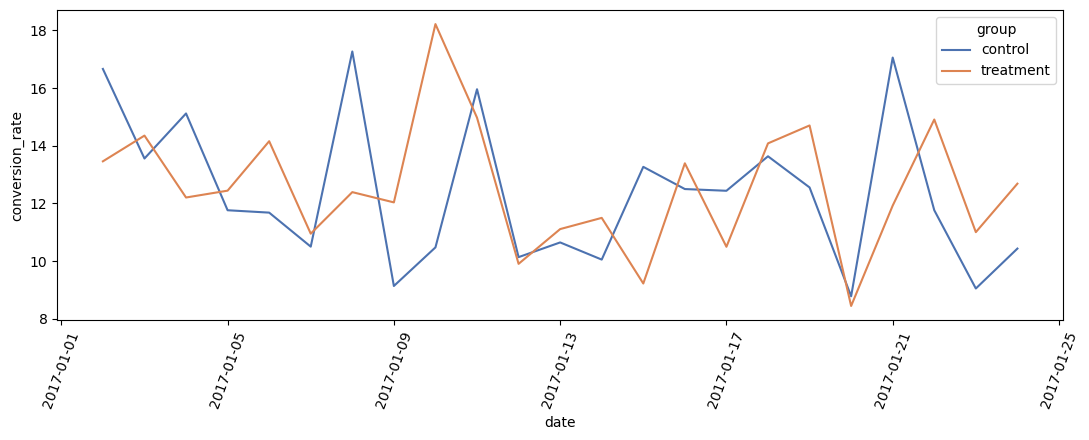

In [26]:
# Plot conversion rate over time segmented by group
fig, ax = plt.subplots(figsize=(11, 4.5))
sns.lineplot(data=cr_time, x="date", y="conversion_rate", hue="group", palette="deep")
plt.xticks(rotation=70)
plt.tight_layout()

Based on the descriptive analysis presented above, there is no clear improvement in the conversion rate between the treatment and control groups. Specifically, 
* The difference in average conversion rate between the two groups are small in magnitude. 
* The trends in conversion rate between the two groups are quite similar overall.

To rigorously test this, I then perform four statistical tests, including three parametric tests and one nonparametric test.

##### 6.3 Peform formal statistical tests

The results from the different statistical tests are consistent with the findings from the descriptive analysis. There are no statistically significant differences between the two groups in terms of conversion rate, with the p-values well above 0.05.

In the case of bootstrapping methods, after bootstrapping 1,000 times, the treatment has a higher conversion rate only about 63.1% of the time, which is close to 50%. Similarly, when examining the distribution of the differences in average conversion rates, it is observed that they cluster around zero, with about half of the instances falling to the left and the other half to the right. The 95% Confidence Interval which covers null also confirms the finding. 

###### 6.3.1 Two-sample T-test

In [27]:
sample1 = sample[sample['group']=='control']['converted']
sample2 = sample[sample['group']=='treatment']['converted']

t_stat, pval =  st.ttest_ind(sample1, sample2)
print('The t-test value is {:.3f}. \nThe p-value is {:.3f}.'.format(t_stat, pval))

The t-test value is -0.343. 
The p-value is 0.732.


###### 6.3.2 Two-sample Proportion Z-test

In [28]:
n1 = sample1.count()
n2 = sample2.count()
c1 = sample1.sum()
c2 = sample2.sum()

sample_n = [n1, n2]
sample_c = [c1, c2]

z_score, p_value = proportions_ztest(count=sample_c, nobs=sample_n, alternative="two-sided")
print('The z-test value is {:.3f}.\nThe p-value is {:.3f}.'.format(z_score, p_value))

The z-test value is -0.343.
The p-value is 0.732.


###### 6.3.3 Chi-square Test

In [29]:
cross_tab = pd.crosstab(index = sample['group'], columns = sample['converted'])
print(cross_tab)

stat, p, dof, expected = st.chi2_contingency(cross_tab)
print('The Chi-Square value is {:.3f}.\nThe p-value is {:.3f}.'.format(stat,p))

converted     0    1
group               
control    4139  582
treatment  4128  593
The Chi-Square value is 0.097.
The p-value is 0.755.


###### 6.3.4 Bootstrapping

In [30]:
boot_means = []

# run the simulation for 1,000 times 
for i in range(1000):
    #frac=1 means randomize the order of all rows 
    boot_sample = sample.sample(frac=1, replace=True).groupby('group')['converted'].mean()
    boot_means.append(boot_sample)

boot_means = pd.DataFrame(boot_means)
boot_means

group,control,treatment
converted,0.127550,0.129990
converted,0.120464,0.121863
converted,0.118529,0.133574
converted,0.124131,0.119864
converted,0.126322,0.131891
...,...,...
converted,0.129504,0.123624
converted,0.123879,0.117647
converted,0.122483,0.126054
converted,0.113578,0.121059


In [31]:
# create the difference between the two variants, scaled by the control group
boot_means['diff'] = (boot_means['treatment'] - boot_means['control'])/boot_means['control']
boot_means

group,control,treatment,diff
converted,0.127550,0.129990,0.019127
converted,0.120464,0.121863,0.011613
converted,0.118529,0.133574,0.126927
converted,0.124131,0.119864,-0.034374
converted,0.126322,0.131891,0.044085
...,...,...,...
converted,0.129504,0.123624,-0.045404
converted,0.123879,0.117647,-0.050304
converted,0.122483,0.126054,0.029157
converted,0.113578,0.121059,0.065868


Text(0.5, 0, 'diff in means')

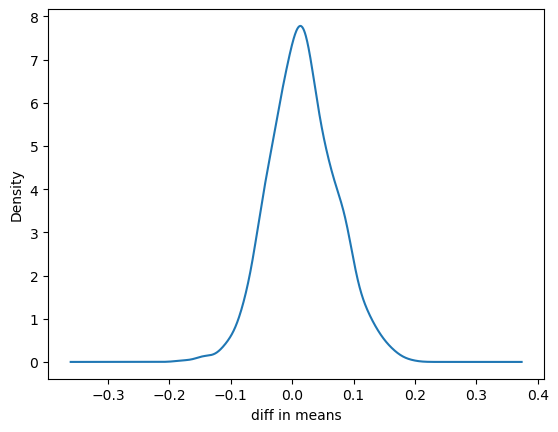

In [32]:
ax = boot_means['diff'].plot(kind = 'kde')
ax.set_xlabel("diff in means")

In [33]:
p = (boot_means['diff'] > 0).sum()/len(boot_means)
print(p)

0.619


In [34]:
lower_bound = np.percentile(boot_means, 2.5)
upper_bound = np.percentile(boot_means, 97.5)
print("95% Confidence Interval:", lower_bound, upper_bound)

95% Confidence Interval: -0.05633744682048918 0.13396950790592407


In [35]:
# # kernel density estimate
# boot_means.plot(kind = 'kde')

### Part 4 - Conclusion

Based on both the descriptive and statistical results, one cannot reject the null hypothesis. This implies that the new page design does not perform significantly better in conversion rate than the old landing page. Therefore, it is recommended that the company does NOT proceed with scaling up the new design site-wide.